In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.L1_REG = 0
config.IS_CONVOLUTIONAL = False
config.EWC_IMPORTANCE = 100
config.SAVE_PATH = './models/permuted_minst/kernel_comparison'
config.MODEL_NAME = 'gaussian'
print(config)

confing_relu = copy.copy(config)
confing_relu.MODEL_NAME = 'relu'

confing_softplus = copy.copy(config)
confing_softplus.MODEL_NAME = 'softplus'

confing_poly = copy.copy(config)
confing_poly.MODEL_NAME = 'poly'

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 100
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: gaussian
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kernel_comparison
USE_EWC: True
USE_TENSORBOARD: True



In [5]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [6]:
def copy_weights(net1, net2):
    model_dict = net1.state_dict()
    pretrained_dict = {k: v for k, v in net2.state_dict().items() if 'dict' not in k and 'alpha' not in k}
    model_dict.update(pretrained_dict)
    return model_dict

gaussian_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8), kernel='gaussian', 
                             kaf_init_fcn=None)

relu_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8), kernel='relu', 
                        kaf_init_fcn=None, D=5)

softplus_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8), kernel='softplus',
                        kaf_init_fcn=None)

poly_net = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8), kernel='gaussian',
                        kaf_init_fcn=None)

relu_net.load_state_dict(copy_weights(relu_net, gaussian_net))
softplus_net.load_state_dict(copy_weights(softplus_net, gaussian_net))
poly_net.load_state_dict(copy_weights(poly_net, gaussian_net))

In [7]:
trainer_gaussian = Trainer(gaussian_net, copy.deepcopy(dataset), config)

metrics_gaussian = trainer_gaussian.load()
if not metrics_gaussian:
    metrics_gaussian = trainer_gaussian.all_tasks()

In [8]:
trainer_relu = Trainer(relu_net, copy.deepcopy(dataset), confing_relu)

metrics_relu = trainer_relu.load()
if not metrics_relu:
    metrics_relu = trainer_relu.all_tasks()

Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:06<00:00, 136.47it/s, loss=1.31, batch#=875]
Testing task 0: 219it [00:01, 165.73it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:05<00:00, 153.78it/s, loss=0.489, batch#=875]
Testing task 0: 219it [00:01, 198.23it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:05<00:00, 153.52it/s, loss=0.392, batch#=875]
Testing task 0: 219it [00:01, 199.83it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:05<00:00, 152.31it/s, loss=0.348, batch#=875]
Testing task 0: 219it [00:01, 195.38it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:05<00:00, 152.41it/s, loss=0.316, batch#=875]
Testing task 0: 219it [00:01, 202.14it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:05<00:00, 153.69it/s, loss=0.293, batch#=875]
Testing task 0: 219it [00:01, 199.30it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100

Testing task 1: 219it [00:01, 215.11it/s, batch#=219]
Testing task 2: 219it [00:01, 216.36it/s, batch#=219]
Training task (ewc) 3, epoch 11: 100%|██████████| 875/875 [00:06<00:00, 129.29it/s, loss=0.463, batch#=875]
Testing task 3: 219it [00:01, 218.46it/s, batch#=219]
Testing task 0: 219it [00:01, 204.50it/s, batch#=219]
Testing task 1: 219it [00:01, 216.50it/s, batch#=219]
Testing task 2: 219it [00:01, 214.31it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [00:06<00:00, 128.04it/s, loss=0.449, batch#=875]
Testing task 3: 219it [00:01, 208.90it/s, batch#=219]
Testing task 0: 219it [00:01, 208.11it/s, batch#=219]
Testing task 1: 219it [00:01, 207.60it/s, batch#=219]
Testing task 2: 219it [00:01, 207.22it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [00:06<00:00, 128.61it/s, loss=0.441, batch#=875]
Testing task 3: 219it [00:01, 198.92it/s, batch#=219]
Testing task 0: 219it [00:01, 205.11it/s, batch#=219]
Testing task 1: 219it [00:01

In [9]:
trainer_softplus = Trainer(softplus_net, copy.deepcopy(dataset), confing_softplus)

metrics_softplus = trainer_softplus.load()
if not metrics_softplus:
    metrics_softplus = trainer_softplus.all_tasks()

In [10]:
trainer_poly = Trainer(poly_net, copy.deepcopy(dataset), confing_poly)

metrics_poly = trainer_poly.load()
if not metrics_poly:
    metrics_poly = trainer_poly.all_tasks()

Gaussian {'fwt': 0.9368571428571428, 'bwt': -0.0209761904761905, 'remembering': 0.9790238095238095, 'pbwt': 0, 'accuracy': 0.44869999999999993}
Relu {'fwt': 0.9044880952380954, 'bwt': -0.04783333333333334, 'remembering': 0.9521666666666666, 'pbwt': 0, 'accuracy': 0.43219285714285716}
Softplus {'fwt': 0.915809523809524, 'bwt': -0.022702380952380974, 'remembering': 0.977297619047619, 'pbwt': 0, 'accuracy': 0.43884285714285715}
Polynomial {'fwt': 0.9415595238095239, 'bwt': -0.015226190476190485, 'remembering': 0.9847738095238096, 'pbwt': 0, 'accuracy': 0.4422499999999999}


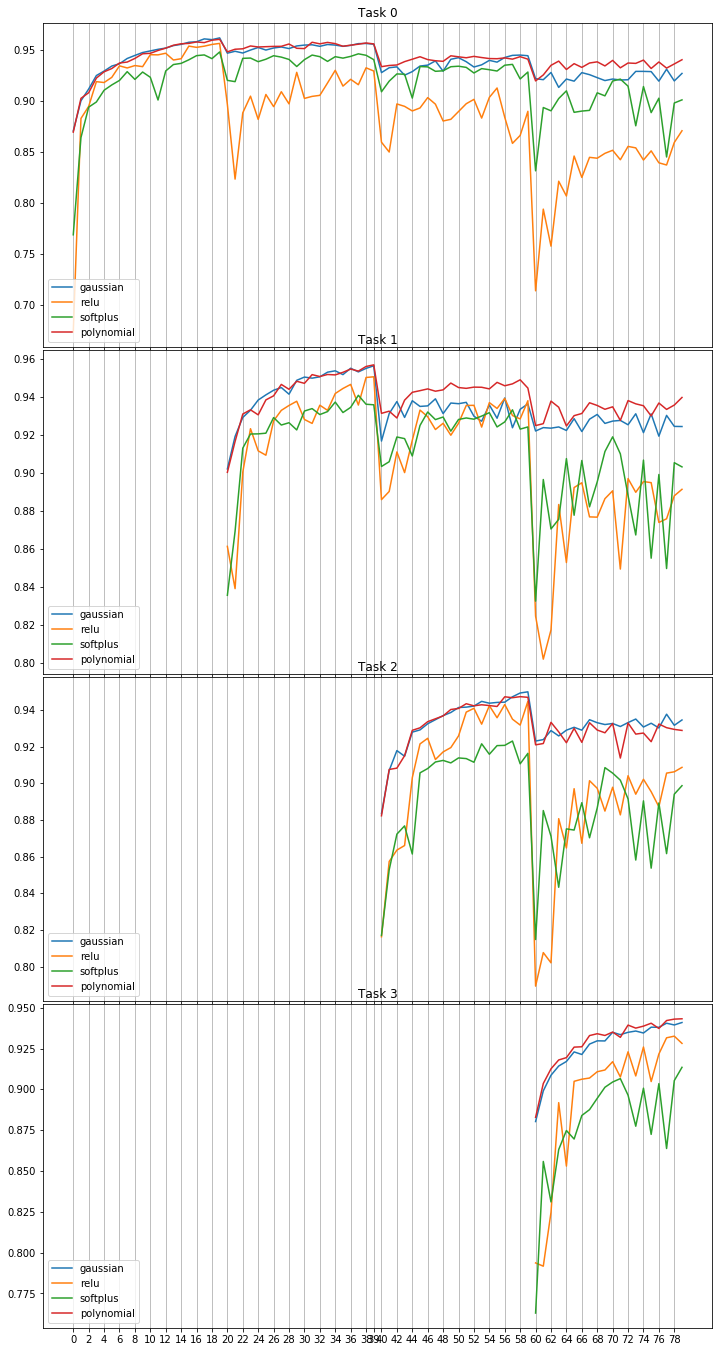

In [11]:
n_task = len(metrics_gaussian['tasks'])
tot_epochs = 0

print('Gaussian', metrics_gaussian['metrics'])
print('Relu', metrics_relu['metrics'])
print('Softplus', metrics_softplus['metrics'])
print('Polynomial', metrics_poly['metrics'])


for k, v in metrics_gaussian['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))

fig = plt.figure(figsize=(12, 24))

ax = None
for i, task in enumerate(metrics_gaussian['tasks'].keys()):
        
    g = metrics_gaussian['tasks'][task]
    r = metrics_relu['tasks'][task]
    s = metrics_softplus['tasks'][task]
    p = metrics_poly['tasks'][task]

    x = range(tot_epochs-len(g['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, g['f1'], label='gaussian')
    ax.plot(x, r['f1'], label='relu')
    ax.plot(x, s['f1'], label='softplus')
    ax.plot(x, p['f1'], label='polynomial')
    
    ax.set_xticks(list(range(0, tot_epochs, 2))+[39],minor=False)
    
    ax.set_title("Task {}".format(task))
    ax.legend(loc="lower left")
    ax.grid(True, axis='x')
    
fig.subplots_adjust(hspace=0.01)


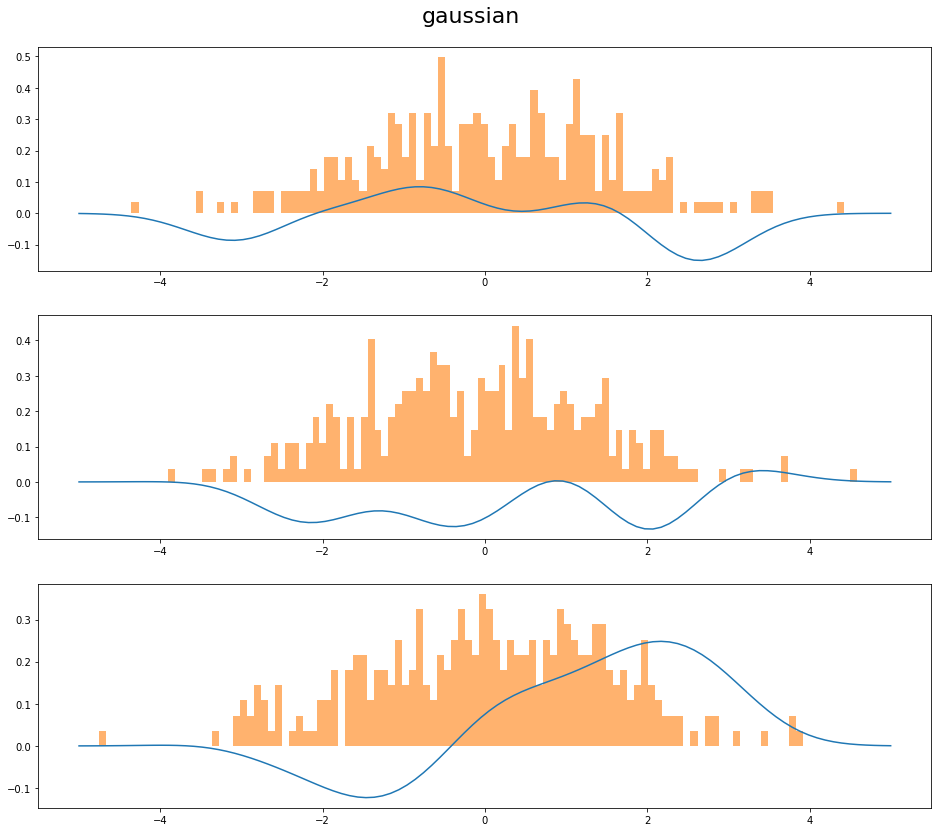

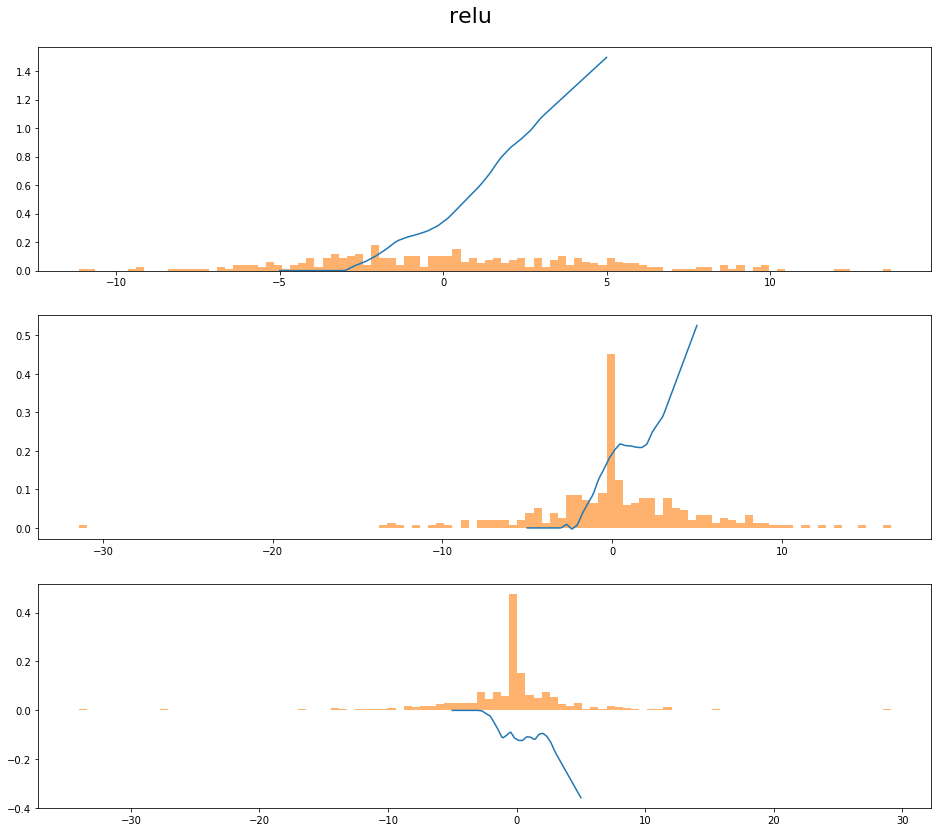

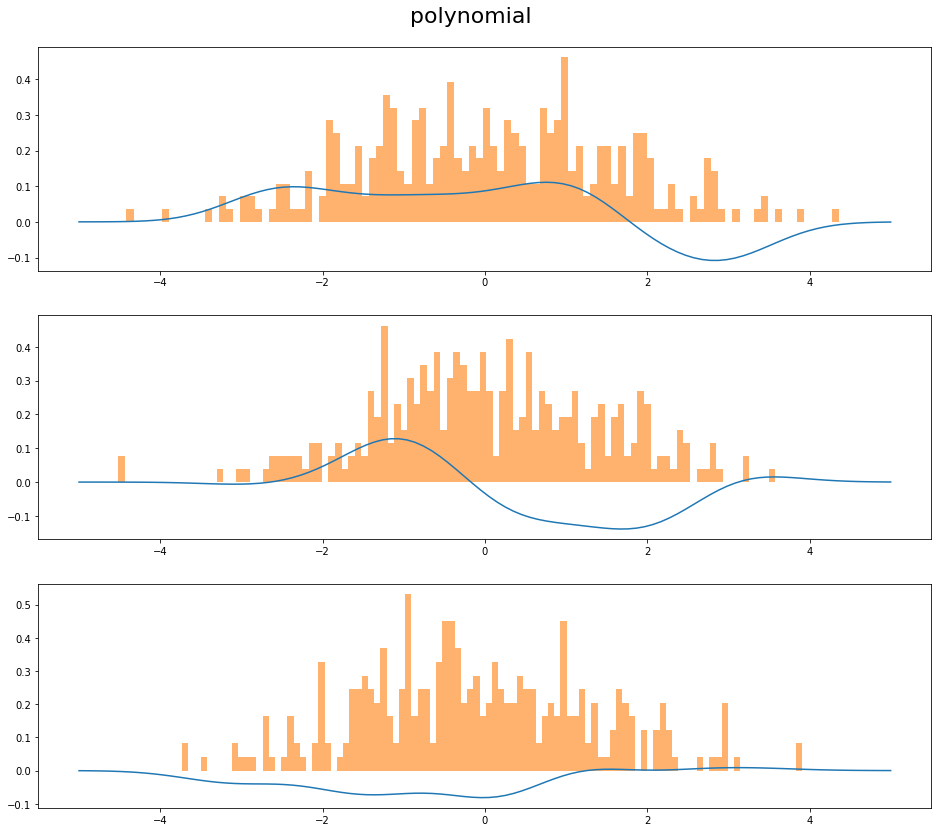

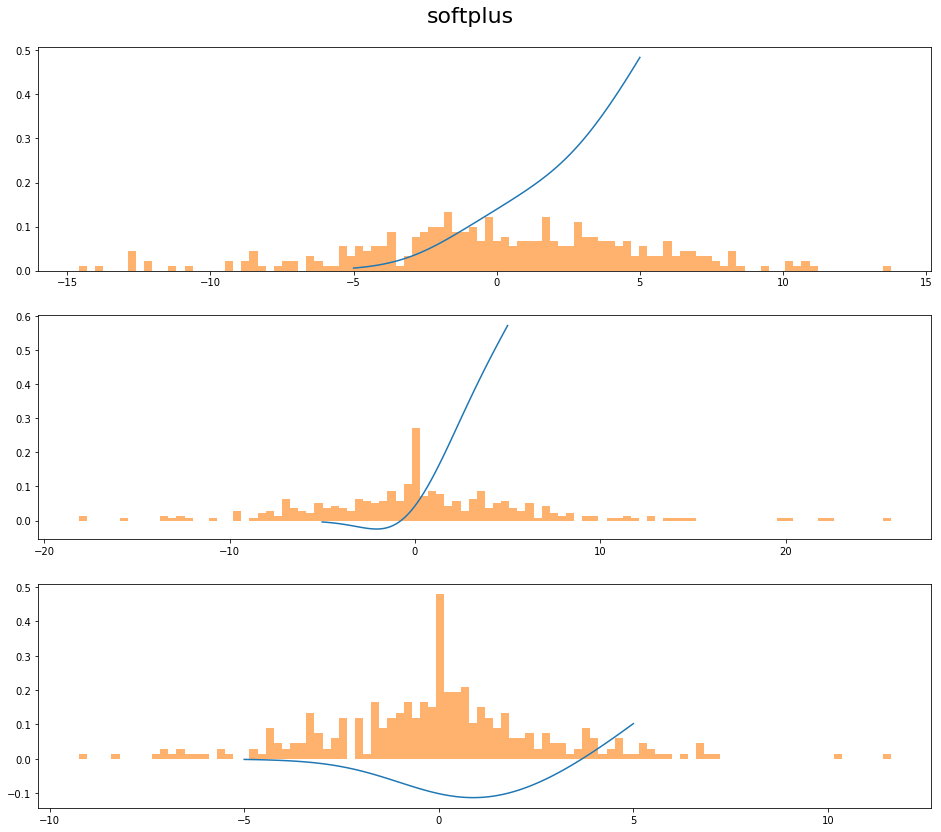

In [12]:
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)
    setattr(module, "_value_hook_input", input)

    
x = list(range(20))
x = np.linspace(-5, 5, 100).astype(np.float32)
common_params = {'histtype': 'step'}
    
for trainer, t in [(trainer_gaussian, 'gaussian'), (trainer_relu, 'relu'),
                   (trainer_poly, 'polynomial'), (trainer_softplus, 'softplus')]:
    model = trainer.model
    fig, ax = plt.subplots(3, 1, sharex=False, figsize=(16, 14))
    fig.suptitle(t, size=22, y=0.92)
    
    for _, m in model.named_modules():
        m.register_forward_hook(hook)
        
    img = dataset[0][0]
    trainer.model(torch.Tensor(img).unsqueeze(0).cuda())
    
    hooked_params = dict(model.named_modules())
    
    for i in [1, 2, 3]:
        name = 'kaf'+str(i)

        c = []
        old = []
        
        for j in x:
            kaf = getattr(model, name)
            input = torch.Tensor([j]).unsqueeze(0).cuda()#.repeat(1, int(400*0.7), 1)
            res = kaf.forward(input).detach().cpu().numpy()[0]
            c.append(np.mean(res))
            
        forward = hooked_params[name]._value_hook.detach().cpu().numpy()[0]
        spl = make_interp_spline(x, c, k=3)
        xnew = np.linspace(min(x), max(x), 100)
        ax[i-1].plot(xnew, spl(xnew))
        
        ax[i-1].hist(x=forward, bins=100, histtype='stepfilled', density=True, alpha=0.6)
        
fig.subplots_adjust()
plt.show()
